<a href="https://colab.research.google.com/github/AntonioCimino/Reconigtion_clothes_in_image/blob/main/Progetto_tesi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Codice per montare Drive di modo da averne accesso per salvare e recuperare infomazioni

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Librerie

import pandas as pd
import numpy as np
import seaborn as sn
import itertools
from scipy.ndimage.interpolation import shift
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from plotly import tools
import plotly.graph_objs as go
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from tensorflow.python import keras
from keras.utils import np_utils
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import os

In [ ]:
#@title Definizioni di variabili globali

IMG_ROWS = 28
IMG_COLS = 28
TEST_SIZE = 0.2
NUM_CLASSES = 10
RANDOM_STATE = 2018

X_test_cut = []
X_test_contrast = []
X_test_brightness = []
X_test_blur = []
X_test_rain = []
X_test_occlusion = []

X_for_train_colored = []
Y_for_train_colored = []
X_for_val_colored = []
Y_for_val_colored = []

X_train_color_change = []
X_val_color_change = []
X_test_color_change = []
Y_test_color_change = []

labels = ['T-shirt/top', 'Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Con AG/ModelDate.csv")

In [ ]:
#@title Funzione per adattare i dati nella dimensione e formato adatto al train

#Metodo per modificare le immagini con lo spostamento verso un dx e dy. 
def shift_image(image, dx, dy):
    shifted_image = shift(image, [dy, dx])
    return shifted_image

#Metodo per aumentare la dimensione del dataset aggiungendo immagini modificate 
#con il metodo shift partendo dalle immagini già presenti nel dataset.
def data_agumentation(dateX , dateY):
    X_train_augmented = []
    y_train_augmented = []

    #Aggiungiamo le immagini del dataset iniziale
    for image, label in zip(dateX, dateY):
      X_train_augmented.append(image)
      y_train_augmented.append(label)   

    #Aggiungiamo le immagini modificate. Per le immagini colorate è stato forzato 
    #l'utilizzo di meno immagini perchè la ram arrivava al limite e stoppava il processo di train.
    for dx, dy in ((1,0), (-1,0), (0,1), (0,-1)):
      for image, label in zip(dateX, dateY):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

    X_for_train_colored = X_train_augmented[:120000]
    Y_for_train_colored = y_train_augmented[:120000]

    #Stampiamo la nuova dimensione del dataset di train
    print('\nNew train dimension then processing date:')
    print('X_train: ' + str(len(X_train_augmented)))
    print('Y_train: ' + str(len(y_train_augmented)) + '\n')
    
    #Mescoliamo il dataset del train per non renderlo troppo macchinoso nel train
    X_train_augmented, y_train_augmented = shuffle(X_train_augmented, y_train_augmented)
    out_x = np.array(X_train_augmented)
    out_y = np.array(y_train_augmented)

    #Applichiamo lo stesso processo per le immagini che coloriamo
    X_for_train_colored, Y_for_train_colored = shuffle(X_for_train_colored, Y_for_train_colored)
    out_x_c = np.array(X_for_train_colored)
    out_y_c = np.array(Y_for_train_colored)
    
    return out_x, out_y, out_x_c, out_y_c    

#Metodo per modificare il formato delle immagini
def data_preprocessing(dateX , dateY):

    #Convertiamo il vettore delle y (ovvero le label che classificano le immagini)
    #da interi ad una matrice di classe binaria per utilizzarla nel processo 
    #di train e test
    out_y = np_utils.to_categorical(dateY, NUM_CLASSES)
    
    #In questo caso non serve la conversione perchè già abbiamo una matrice binaria
    #per le immagini. Quello che facciamo qui è lavorare sul formato delle immagini 
    #ridimensionandole e successivamente normalizzandole
    x_as_array = dateX[:len(dateX)]
    x_shaped_array = x_as_array.reshape(len(dateX), IMG_ROWS, IMG_COLS, 1)
    out_x = x_shaped_array / 255

    return out_x, out_y

In [ ]:
#@title Metodi filtri

#Metodo per aumentare o diminuire la luminosità sull'immagine
def apply_rotate(input_img):     
  buf = cv2.rotate(input_img, cv2.ROTATE_90_CLOCKWISE)
  return buf

#Metodo per aumentare o diminuire la luminosità sull'immagine
def apply_brightness(input_img, brightness):
  if brightness > 0:
    shadow = brightness
    highlight = 255
  else:
    shadow = 0
    highlight = 255 + brightness
  alpha_b = (highlight - shadow)/255
  gamma_b = shadow      
  buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
  return buf

#Metodo per aumentare o diminuire il contrasto sull'immagine
def apply_contrast(input_img, contrast):
  f = 131 * (contrast + 127)/(127*(131-contrast))
  alpha_c = f
  gamma_c = 127*(1-f)      
  buf = cv2.addWeighted(input_img, alpha_c, input_img, 0, gamma_c)
  return buf
        
#Metodo per modificare colore sull'immagine
def color_grayscale_arr(arr):
  dtype = arr.dtype
  h = arr.shape[0]
  w = arr.shape[1]
  arr = np.reshape(arr, [h, w, 1])

  x = np.random.randint(0,3)
  if x == 0:
    #red
    arr = np.concatenate([arr, np.zeros((h, w, 2), dtype=dtype)], axis=2)
  if x == 1:
    #green
    arr = np.concatenate([np.zeros((h, w, 1), dtype=dtype), arr, np.zeros((h, w, 1), dtype=dtype)], axis=2)
  if x == 2:
    #blue
    arr = np.concatenate([np.zeros((h, w, 2), dtype=dtype),arr], axis=2)
  return arr

#Metodo per inserire la pioggia sull'immagine
def add_rain(image):
    imshape = image.shape
    drop_color = (180,180,180)
    bending = 3
    drop_length = 3
    rain_drops = []

    #Definiamo le posizioni delle linee
    for i in range(50):
      x = np.random.randint(0,imshape[1])
      y = np.random.randint(0,imshape[0])
      rain_drops.append((x,y))
    
    #Disegniamo le line (pioggia)
    for drop in rain_drops:
        cv2.line(image,(drop[0],drop[1]), (drop[0] + bending, drop[1] + drop_length),drop_color,1)
    
    #Aggiungiamo un pò di blur per effetto foschia durante la pioggia
    image = cv2.blur(image,(2,2)) 
    return image
        
#Metodo per creare delle occlusioni sull'immagine
def add_occlusion(image):
    imshape = image.shape
    drop_color = (0,0,0) 
    occlusion_drops = []
    
    #Definisco la posizione che avranno le occlusioni
    for i in range(10):
      x = np.random.randint(0,imshape[1])
      y = np.random.randint(0, imshape[0])
      occlusion_drops.append((x,y))

    #Disegno le occlusioni
    for drop in occlusion_drops:
        cv2.circle(image,(drop[0],drop[1]),3,drop_color,-1)

    return image

In [ ]:
#@title Funzione per richiamare filtri

def image_apply_filter(img):
    
  #Inserire filtro per tagliare l'immagine
  out = img[0:int(img.shape[1]), 0:int(img.shape[0]/2)]
  out = cv2.resize(out, (int(img.shape[1]),int(img.shape[0])), interpolation = cv2.INTER_AREA)
  X_test_cut.append(out)
   
  #Inserisco il filtro per aumentare il contrasto
  out = apply_contrast(img, 45)
  X_test_contrast.append(out)

  #Inserisco il filtro per aumentare la luce
  out = apply_rotate(img)
  X_test_brightness.append(out)

  #Inserisco il filtro per sfocare l'immagine
  ksize = (6, 6)
  out = cv2.blur(img, ksize) 
  X_test_blur.append(out)

  #Inserisco il filtro per la pioggia
  rain_img = img.copy()
  out = add_rain(rain_img)
  X_test_rain.append(out)

  #Inserisco il filtro per le occlusioni
  occlusion_img = img.copy()
  out = add_occlusion(occlusion_img)
  X_test_occlusion.append(out)

In [ ]:
#@title Funzione per mostrare i dati

def view_date():
  num_row = 2
  num_col = 5
  images = []
  labels = []
  count_train = [0,0,0,0,0,0,0,0,0,0]
  count_test = [0,0,0,0,0,0,0,0,0,0]
  fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
  label_dict = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover',
            3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt',
            7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

  #Stampiamo la dimesione dei dataset di train e test
  print('Fashion MNIST Dataset Shape:')
  print('X_train: ' + str(X_train.shape))
  print('Y_train: ' + str(Y_train.shape))
  print('X_test:  '  + str(X_test.shape))
  print('Y_test:  '  + str(Y_test.shape) + '\n')

  #Calcoliamo e stampiamo la percentuale di elementi presenti nel dataset per ogni tipo
  for j in range(len(Y_train)):
    count_train[Y_train[j]] = count_train[Y_train[j]] + 1

  for j in range(len(Y_test)):
    count_test[Y_test[j]] = count_test[Y_test[j]] + 1

  for i in range(len(count_train)):
    percent_train = (count_train[i] / len(Y_train)) * 100
    percent_test = (count_train[i] / len(Y_train)) * 100
    print("{:<20s}: Train {} or {}% and Test {} or {}%".format(label_dict[i], 
                    count_train[i], percent_train, count_test[i], percent_test))

  print('\n')

  #Stampiamo un esempio di immagine per ogni tipo nel dataset
  for i in range(num_row*num_col):
    for j in range(len(X_train)):
      if Y_train[j] == i:
        images.append(X_train[j])
        labels.append(Y_train[j])
        break
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('{}'.format(label_dict[labels[i]]))    
    
  plt.tight_layout()
  plt.savefig('/content/drive/MyDrive/Colab Notebooks/Immagine_vestiti.png')
  plt.show()

  print('\n')

  #Stampiamo le immagini con silhouette simili
  images = []
  labels = [0,2,4,6]

  fig2, axes2 = plt.subplots(1, 4, figsize=(1.5*4,2*1))
  for i in range(4):
    for j in range(len(X_train)):
      if Y_train[j] == labels[i]:
        images.append(X_train[j])
        break
    ax = axes2[i]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('{}'.format(label_dict[labels[i]]))    
    
  plt.tight_layout()
  plt.savefig('/content/drive/MyDrive/Colab Notebooks/Immagine_vestiti_silhouette_simili.png')
  plt.show()

  print('\n')

  #Stampiamo una singola immagine e poi le sue copie modificate con la funzione shift
  images = []
  labels = []
  fig, axes = plt.subplots(1, num_col, figsize=(1.5*num_col,2*num_row))

  for dx, dy in ((0,0),(1,0), (-1,0), (0,1), (0,-1)):
    images.append(shift(X_train[3], [dx, dy]))
    labels.append(Y_train[3])

    ax = axes[len(images) - 1]
    ax.imshow(images[len(images) - 1], cmap='gray')
    ax.set_title('{}'.format(label_dict[labels[len(labels) - 1]] + ' + (' + str(dx) + ',' + str(dy) + ')'))    
    
  plt.tight_layout()
  plt.show()

def view_filtered_date():
  #Definiamo la tabella per contenere l'immagine
  fig, axes = plt.subplots(2, 4, figsize=(8,4)) 

  #Inseriamo l'immagine originale
  ax = axes[0, 0]
  ax.imshow(X_test[0])
  ax.set_title('Original') 

  ax = axes[0, 1]
  ax.imshow(X_test_cut[0])
  ax.set_title('Cut')

  ax = axes[0, 2]
  ax.imshow(X_test_contrast[0])
  ax.set_title('Contrast')

  ax = axes[0, 3]
  ax.imshow(X_test_brightness[0])
  ax.set_title('Rotate')

  ax = axes[1, 0]
  ax.imshow(X_test_blur[0])
  ax.set_title('Blur')

  ax = axes[1, 1]
  ax.imshow(X_test_color_change[0])
  ax.set_title('Color change')

  ax = axes[1, 2]
  ax.imshow(X_test_rain[0], cmap = 'gray')
  ax.set_title('Rain')

  ax = axes[1, 3]
  ax.imshow(X_test_occlusion[0])
  ax.set_title('Occlusion')

  #Stampo la tabella
  plt.tight_layout()
  plt.show()  

def view_filtered_date_for_single_class(X_train,Y_train,nome_filtro):
  num_row = 2
  num_col = 5
  images = []
  labels = []
  label_dict = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover',
            3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt',
            7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

  fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
  #Stampiamo un esempio di immagine per ogni tipo nel dataset con filtri
  for i in range(num_row*num_col):
    for j in range(len(X_train)):
      if Y_train[j] == i:
        images.append(X_train[j])
        labels.append(Y_train[j])
        break
    ax = axes[i//num_col, i%num_col]
    if nome_filtro == 'rain':
      ax.imshow(images[i], cmap='gray')
    else:
      ax.imshow(images[i])
    ax.set_title('{}'.format(label_dict[labels[i]]))    
    
  plt.tight_layout()
  plt.savefig('/content/drive/MyDrive/Colab Notebooks/Immagine_vestiti_' + nome_filtro + '.png')
  plt.show()

In [ ]:
#@title Metodo per creare e salvare i dataset di accuratezza e loss
def plot_accuracy_and_loss(model, x):
  
  #Per ogni modello estraiamo i dati per costrire i grafici
  hist = model.history
  acc = hist['accuracy']
  val_acc = hist['val_accuracy']
  loss = hist['loss']
  val_loss = hist['val_loss']
    
  #Creiamo il grafico di accuratezza  
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('model accuracy') 
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')

  #Salvaimo il grafico di accuratezza
  if not os.path.exists("/content/drive/MyDrive/Colab Notebooks/Grafici_Accuracy"):
    os.makedirs("/content/drive/MyDrive/Colab Notebooks/Grafici_Accuracy")

  plt.savefig('/content/drive/MyDrive/Colab Notebooks/Grafici_Accuracy/Grafico_Accuracy_' + str(x) + '.png')
  plt.show()

  #Creiamo il grafico di loss 
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')

  #Salvaimo il grafico di loss
  if not os.path.exists("/content/drive/MyDrive/Colab Notebooks/Grafici_Loss"):
    os.makedirs("/content/drive/MyDrive/Colab Notebooks/Grafici_Loss")

  plt.savefig('/content/drive/MyDrive/Colab Notebooks/Grafici_Loss/Grafico_Loss_' + str(x) + '.png')
  plt.show()

In [ ]:
#@title Metodo per creare la matrice di confusione
def plot_confusion_matrix(x,tipo_dati, cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=25)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, rotation=0, fontsize=15)
    plt.grid(False)
    plt.rcParams.update({'font.size': 16})
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

    if not os.path.exists("/content/drive/MyDrive/Colab Notebooks/" + tipo_dati + '/Confusion_Matrix'):
      os.makedirs("/content/drive/MyDrive/Colab Notebooks/" + tipo_dati + '/Confusion_Matrix')
    
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/' + tipo_dati + '/Confusion_Matrix/Confusion_Matrix_' + str(x) + '.png')

In [ ]:
#@title Metodo che inizializza il modello

def initializate_model(channel):
  
  #Il modello Sequential è una pila lineare di livelli, a cui aggiungiamo 
  #livelli tramite il metodo add()  
  model = Sequential()

  #Conv2D è un livello di convoluzione 2D. Questo livello crea un kernel. Nell'elaborazione delle immagini il kernel è una matrice di convoluzione o 
  #maschere che possono essere utilizzate per sfocare, aumentare la nitidezza, rilievo, rilevamento dei bordi e altro facendo una convoluzione tra un 
  #kernel e un'immagine. Il primo valore è il numero di filtri da cui impareranno i livelli convoluzionali, il secondo la dimensione del kernel e l'ultimo
  #la dimensione dell'input. Il parametro di attivazione consente di fornire una stringa, che specifica il nome della funzione che si desidera applicare 
  #dopo aver eseguito la convoluzione, in questo caso applica la funzione di attivazione dell'unità lineare rettificata. Gli inizializzatori definiscono 
  #il modo per impostare i pesi casuali, nel nostro caso utilizziamo una funzione normale. 
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', 
          kernel_initializer='he_normal', input_shape=(IMG_ROWS, IMG_COLS, channel)))

  #Sottocampiona l'input lungo le sue dimensioni spaziali (altezza e larghezza) prendendo il valore massimo su una finestra di input (di dimensione definita 
  #da pool_size, che nel nostro caso è 2,2) per ogni canale dell'ingresso. La finestra viene spostata lungo ogni dimensione.   
  model.add(MaxPooling2D((2, 2)))

  #Il dropout è una tecnica in cui i neuroni selezionati casualmente vengono "abbandonati" casualmente. I pesi dei neuroni sono sintonizzati per 
  #caratteristiche specifiche, fornendo una certa specializzazione. Se i neuroni vengono eliminati casualmente dalla rete durante l'allenamento, altri 
  #neuroni dovranno intervenire e gestire la rappresentazione richiesta per fare previsioni per i neuroni mancanti. Si ritiene che ciò comporti 
  #l'apprendimento da parte della rete di più rappresentazioni interne indipendenti. Il valore tra parentesi è la percentuale di neuroni abbandonati.
  model.add(Dropout(0.25))

  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

  model.add(MaxPooling2D((2, 2)))

  model.add(Dropout(0.25))

  model.add(Conv2D(128, (3, 3), activation='relu'))

  model.add(Dropout(0.4))

  #Serve ad appiattire gli input. Ovvero da una matrice di input passiamo ad un array da passare al prossimo livello.
  model.add(Flatten())

  #E' un normale livello NN densamente connesso. 
  model.add(Dense(128, activation='relu'))

  model.add(Dropout(0.3))

  model.add(Dense(NUM_CLASSES, activation='softmax'))

  #Per addestrare un modello, è necessario specificare una funzione di perdita, un ottimizzatore, ed eventualmente, alcune metriche da monitorare.
  #Si passano questi attraverso la funzione compile().
  model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
  
  #Serve a stampare la tabelle del riepilogo del modello.
  model.summary()

  return model

In [ ]:
#@title Metodo per il test

def try_model(date, tipo_dati):

  if not os.path.exists("/content/drive/MyDrive/Colab Notebooks/" + tipo_dati):
    os.makedirs("/content/drive/MyDrive/Colab Notebooks/" + tipo_dati)
  
  #File dove inseriamo i risultati
  file = open("/content/drive/MyDrive/Colab Notebooks/" + tipo_dati +"/ModelResult.txt", "w")

  for x in range(len(df)):
  
    #Carichiamo i modelli
    if tipo_dati == 'Test_color_image':
      model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Con AG and Color/Modelli_with_colored_image/Modello_' + str(x) + '.csv')
    else:  
      model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Con AG/Modelli/Modello_' + str(x) + '.csv')

    file.write('Modello ' + str(x) + '\n\n')

    #Restituisce i valore di predizione sul dataset di test
    predicted_classes = np.argmax(model.predict(date), axis=-1)
    p = predicted_classes[:10000]
  
    #Facciamo il confronto per capire quanto sia stato accurato
    correct = np.nonzero(p==y)[0]
    incorrect = np.nonzero(p!=y)[0]
    file.write("Correct predicted classes: " + str(correct.shape[0]) + '\n')
    file.write("Incorrect predicted classes: " + str(incorrect.shape[0]) + '\n')
    file.write("Accuracy: " + str(correct.shape[0]/10000) + '\n')
    file.write('\n')

    #Stampa altri valori utili all'analisi del modello
    target_names = ["Class {} ({}) :".format(i,labels[i]) for i in range(NUM_CLASSES)]
    report = classification_report(y, predicted_classes, target_names=labels)
    file.write(report)

    file.write('\n------------------------------------------------------------\n')

    #Crea e salva la matrice di confusione
    cm = confusion_matrix(y, p)
    plt.figure(figsize=(15,10))
    plot_confusion_matrix(x,tipo_dati, cm, labels)

  file.close()

4422102/4422102 [==============================] - 0s 0us/step
Fashion MNIST Dataset Shape:
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)

T-shirt/top         : Train 6000 or 10.0% and Test 1000 or 10.0%
Trouser             : Train 6000 or 10.0% and Test 1000 or 10.0%
Pullover            : Train 6000 or 10.0% and Test 1000 or 10.0%
Dress               : Train 6000 or 10.0% and Test 1000 or 10.0%
Coat                : Train 6000 or 10.0% and Test 1000 or 10.0%
Sandal              : Train 6000 or 10.0% and Test 1000 or 10.0%
Shirt               : Train 6000 or 10.0% and Test 1000 or 10.0%
Sneaker             : Train 6000 or 10.0% and Test 1000 or 10.0%
Bag                 : Train 6000 or 10.0% and Test 1000 or 10.0%
Ankle boot          : Train 6000 or 10.0% and Test 1000 or 10.0%




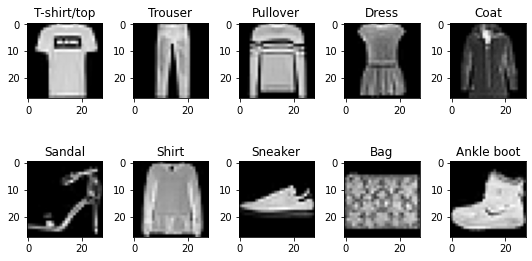

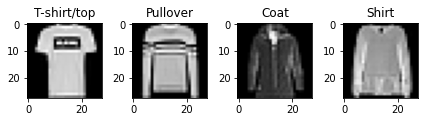

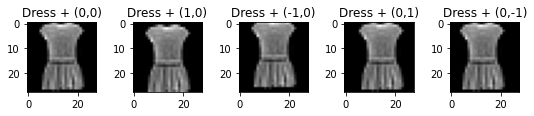

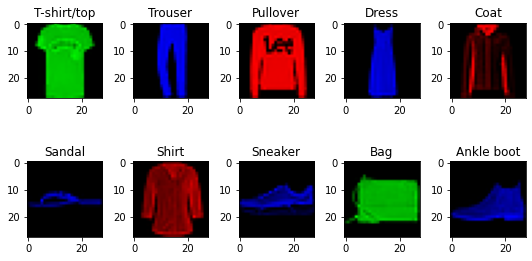

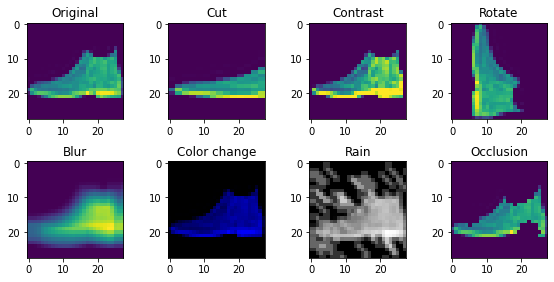


New train dimension then processing date:
X_train: 300000
Y_train: 300000



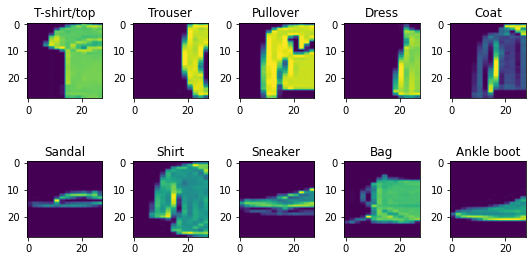

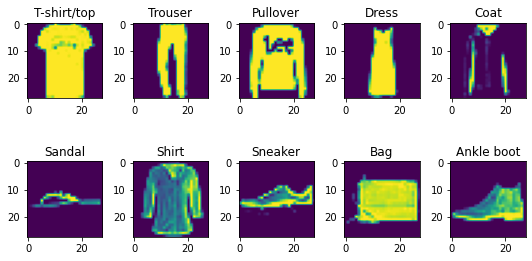

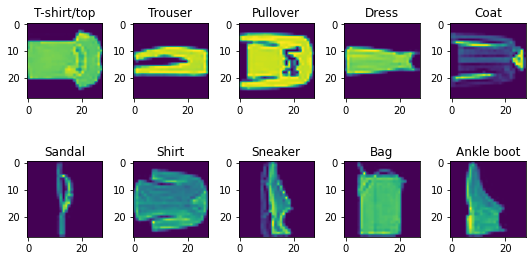

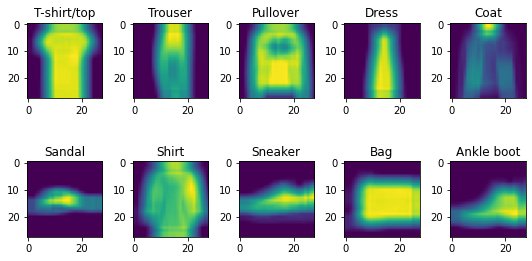

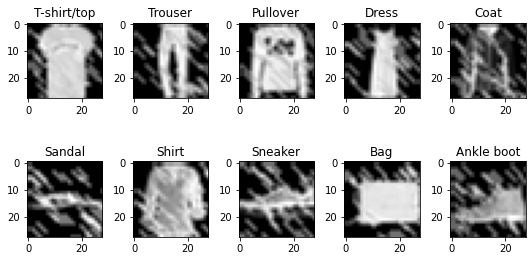

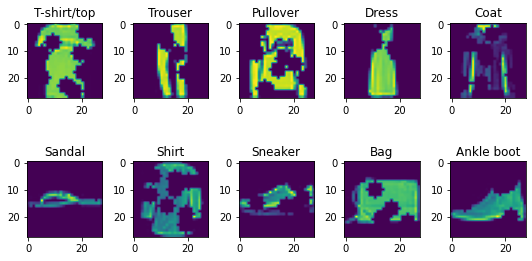

In [ ]:
#@title Script di codice per importare i dati e lavorarli con le funzioni precedenti

#Importiamo il dataset
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

#Visualizziamo i dati
view_date()

#Questa funzione applica tutti i filtri sulle immagini dei test
for img in X_test:
  image_apply_filter(img)

#Definiamo le immagini colorate per il test
for i in range(len(X_test)):
  colored_arr = color_grayscale_arr(X_test[i])
  X_test_color_change.append(colored_arr)
  Y_test_color_change.append(Y_test[i])

view_filtered_date_for_single_class(X_test_color_change, Y_test_color_change,'colored')

#Vediamo i dati con i filtri applicati
view_filtered_date()

#Effettuiamo la Data Augumentation
X_train, Y_train, X_for_train_colored, Y_for_train_colored = data_agumentation(X_train, Y_train)

#Processiamo i dati di train
X_train, Y_train = data_preprocessing(X_train, Y_train)
X_for_train_colored, Y_for_train_colored = data_preprocessing(X_for_train_colored, Y_for_train_colored)

#Prendiamo una parte dei dati nel train per la valutazione durante il train
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=TEST_SIZE, random_state=RANDOM_STATE)
X_for_train_colored, X_for_val_colored, Y_for_train_colored, Y_for_val_colored = train_test_split(
    X_for_train_colored, Y_for_train_colored, test_size=TEST_SIZE, random_state=RANDOM_STATE)

#Generiamo i dati per il train con immagini colorate, procediamo con inserire il filtro sulle immagini
for img in X_for_train_colored:
  colored_arr = color_grayscale_arr(img)
  X_train_color_change.append(colored_arr)

for img in X_for_val_colored:
  colored_arr = color_grayscale_arr(img)
  X_val_color_change.append(colored_arr)

#Creiamo una lista di valori per il test per valutare successivamente, prima di processare i dati
y = Y_test[:10000]

#Processiamo i dati di test
X_test, Y_test = data_preprocessing(X_test, y)

view_filtered_date_for_single_class(X_test_cut, y,'cut')
X_test_cut, Y_test_cut = data_preprocessing(np.array(X_test_cut), y)

view_filtered_date_for_single_class(X_test_contrast, y,'contrast')
X_test_contrast, Y_test_contrast = data_preprocessing(np.array(X_test_contrast), y)

view_filtered_date_for_single_class(X_test_brightness, y,'brightness')
X_test_brightness, Y_test_brightness = data_preprocessing(np.array(X_test_brightness), y)

view_filtered_date_for_single_class(X_test_blur, y,'blur')
X_test_blur, Y_test_blur = data_preprocessing(np.array(X_test_blur), y)

view_filtered_date_for_single_class(X_test_rain, y,'rain')
X_test_rain, Y_test_rain = data_preprocessing(np.array(X_test_rain), y)

view_filtered_date_for_single_class(X_test_occlusion, y,'occlusion')
X_test_occlusion, Y_test_occlusion = data_preprocessing(np.array(X_test_occlusion), y)

In [ ]:
#@title Train

for x in range(len(df)):
  model = initializate_model(1)
  history = model.fit(X_train, Y_train,
            batch_size=int(df["Batch_size"][x]),
            epochs=int(df["Epoche"][x]),
            verbose=1,
            validation_data=(X_val, Y_val))
  if not os.path.exists("/content/drive/MyDrive/Colab Notebooks/Modelli/"):
    os.makedirs("/content/drive/MyDrive/Colab Notebooks/Modelli/")
  model.save('/content/drive/MyDrive/Colab Notebooks/Modelli/Modello_' + str(x) + '.csv')
  plot_accuracy_and_loss(history, x)

In [ ]:
#@title Train con le immagini colorate

for x in range(len(df)):
  if x == 5:
    model = initializate_model(3)
    history = model.fit(np.array(X_train_color_change), Y_for_train_colored,
            batch_size=int(df["Batch_size"][x]),
            epochs=int(df["Epoche"][x]),
            verbose=1,
            validation_data=(np.array(X_val_color_change), Y_for_val_colored))

    if not os.path.exists("/content/drive/MyDrive/Colab Notebooks/Modelli_with_colored_image/"):
      os.makedirs("/content/drive/MyDrive/Colab Notebooks/Modelli_with_colored_image/")
    model.save('/content/drive/MyDrive/Colab Notebooks/Modelli_with_colored_image/Modello_' + str(x) + '.csv')
    plot_accuracy_and_loss(history, x)

In [ ]:
#@title Test

try_model(X_test, 'Test_original_image')
try_model(X_test_cut, 'Test_cut_image')
try_model(X_test_blur, 'Test_blur_image')
try_model(X_test_contrast, 'Test_contrast_image')
try_model(X_test_brightness, 'Test_brightness_image')
try_model(X_test_rain, 'Test_rain_image')
try_model(X_test_occlusion, 'Test_occlusion_image')
#try_model(np.array(X_test_color_change), 'Test_color_image')